In [1]:
from ponyge2_adapted_files import Grammar, ge
import algorithms
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deap import creator, base, tools
from sklearn.model_selection import train_test_split
import math
import textwrap
import csv

import warnings
warnings.filterwarnings("ignore")

In [2]:
x = np.arange(0, 100)
y = lambda x: 6 * x + 4 
noise = np.random.randint(1, 5, size=x.shape)
y_noised = y(x) + noise

X_train, X_test, y_train, y_test = train_test_split(x, y_noised, test_size=0.1, shuffle=True) 


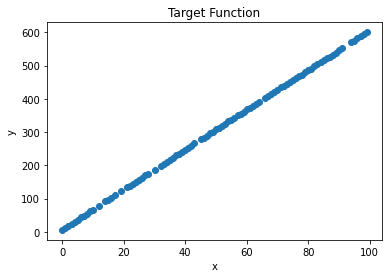

In [5]:
plt.scatter(X_train, y_train)
plt.title("Target Function")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

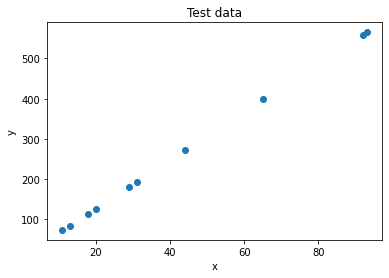

In [6]:
plt.scatter(X_test, y_test)
plt.title("Test data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [7]:
X_train = np.array([x/10. for x in range(-20,20)])
y_train = y(X_train)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, shuffle=True) 

In [8]:
GRAMMAR_FILE = 'basic-regression-grammar.bnf'
BNF_GRAMMAR = Grammar(path.join("../grammars", GRAMMAR_FILE))

In [9]:
def write_stat(value, file_name, mode):
    with open(file_name, mode) as write_file:
        write_file.write(str(value))
        write_file.write("\n")


def read_stat(file_name):
    with open(file_name, "r") as write_file:
        cnt = int(write_file.read())
    return cnt

In [26]:
### cold-start
with open("out-files/statistics-cfg.txt", "w") as write_file:
    # write_file.write(str(0))
    write_file.write(str(""))

In [27]:
ε = 1e-8

def fitness_eval(individual, points):
    #points = [X, Y]
    x = points[0]
    y = points[1]
    
    if individual.invalid == True:
        return np.NaN,
    try:
        pred = eval(individual.phenotype)
    # except (FloatingPointError, ZeroDivisionError, OverflowError,
    #         MemoryError, ValueError):
    except Exception as e:
        write_stat(e, "out-files/statistics-cfg.txt", "a")
        return np.NaN,
    assert np.isrealobj(pred)
    
    try:
        # fitness = 1/np.mean(np.square(y - pred))
        fitness = np.mean(np.square(y - pred))
    # except (FloatingPointError, ZeroDivisionError, OverflowError,
    #         MemoryError, ValueError):
    except Exception as e:
        write_stat(e, "out-files/statistics-cfg.txt", "a")
        fitness = np.NaN
        
    if fitness == float("inf"):
        return np.NaN,
    return fitness, 

In [28]:
toolbox = base.Toolbox()

# define a single objective, minimising fitness strategy:
# creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))


# creator.create('Individual', ge.Individual, fitness=creator.FitnessMax)
creator.create('Individual', ge.Individual, fitness=creator.FitnessMin)

toolbox.register("populationCreator", ge.initialisation_PI_Grow, creator.Individual) 

toolbox.register("evaluate", fitness_eval)#, points=[X_train, Y_train])

# Tournament selection:
toolbox.register("select", ge.selTournament, tournsize=3)

# Single-point crossover:
toolbox.register("mate", ge.crossover_onepoint)

# Flip-int mutation:
toolbox.register("mutate", ge.mutation_int_flip_per_codon)


In [29]:
N_RUNS = 32
POPULATION_SIZE = 200
MAX_GENERATIONS = 20
P_CROSSOVER = 0.9
P_MUTATION = 0.01
ELITE_SIZE = round(0.01*POPULATION_SIZE)

HALL_OF_FAME_SIZE = 1
MAX_INIT_TREE_DEPTH = 5
MIN_INIT_TREE_DEPTH = 1
MAX_TREE_DEPTH = 17
MAX_WRAPS = 0
CODON_SIZE = 255

In [30]:
maxListFitness = []
avgListFitness = []
minListFitness = []
stdListFitness = []

maxListSize = []
avgListSize = []
minListSize = []
stdListSize = []
bestListSize = []

In [31]:
for r in range(0, N_RUNS):
    # create initial population (generation 0):
    population = toolbox.populationCreator(size=POPULATION_SIZE, 
                                            bnf_grammar=BNF_GRAMMAR, 
                                            min_init_tree_depth=MIN_INIT_TREE_DEPTH,
                                            max_init_tree_depth=MAX_INIT_TREE_DEPTH,
                                            max_tree_depth=MAX_TREE_DEPTH, 
                                            max_wraps=MAX_WRAPS,
                                            codon_size=CODON_SIZE
                                            )
    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)             
    # prepare the statistics object:
    #stats = tools.Statistics(key=lambda ind: ind.fitness.values if math.isnan(ind.fitness.values[0]) else None)#ind.fitness.values != np.inf else None)
    #stats = tools.Statistics(key=lambda ind: ind.fitness.values[0] if not math.isnan(ind.fitness.values[0]) else np.NaN)#ind.fitness.values != np.inf else None)
    stats = tools.Statistics(key=lambda ind: ind.fitness.values)# if not ind.invalid else (np.NaN,))#ind.fitness.values != np.inf else None)
    stats.register("avg", np.nanmean)
    stats.register("std", np.nanstd)
    stats.register("min", np.nanmin)
    stats.register("max", np.nanmax)
    
    # Which run are we on?
    print("\n\nCurrently on run", r, "of",N_RUNS)
    # perform the Grammatical Evolution flow:
    population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                          ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                          bnf_grammar=BNF_GRAMMAR, codon_size=CODON_SIZE, 
                                          max_tree_depth=MAX_TREE_DEPTH, max_wraps=MAX_WRAPS,
                                          points_train=[X_train, y_train], 
                                          points_test=[X_test, y_test], 
                                          stats=stats, halloffame=hof, verbose=True)

    max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
    min_fitness_values, std_fitness_values = logbook.select("min", "std")
    
    # fitness_test = logbook.select("fitness_test")
    best_ind_length = logbook.select("best_ind_length")
    avg_length = logbook.select("avg_length")
    max_length = logbook.select("max_length")
    # selection_time = logbook.select("selection_time")
    # generation_time = logbook.select("generation_time")
    # gen, invalid = logbook.select("gen", "invalid")

    # Save statistics for this run:
    avgListFitness.append(mean_fitness_values)
    stdListFitness.append(std_fitness_values)
    minListFitness.append(min_fitness_values)
    maxListFitness.append(max_fitness_values)

    avgListSize.append(avg_length)
    bestListSize.append(best_ind_length)
    # stdListSize.append(stdSizeValues)
    # minListSize.append(minSizeValues)
    maxListSize.append(max_length)

    best = hof.items[0].phenotype 
    print("Best individual: \n","\n".join(textwrap.wrap(best,80)))
    print("\nTraining Fitness: ", hof.items[0].fitness.values[0])
    print("Depth: ", hof.items[0].depth)
    print("Length of the genome: ", len(hof.items[0].genome))
    print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')     
    write_stat("end of run", "out-files/statistics-cfg.txt", "a")                    



Currently on run 0 of 32
gen	invalid	avg    	std    	min    	max    	fitness_test	best_ind_length	avg_length	max_length	selection_time	generation_time
0  	0      	52.4228	5.89177	47.0767	100.577	48.51       	9              	8.34      	22        	0             	0.013222       
1  	61     	49.7449	2.30533	47.05  	64.8233	54.61       	18             	8.205     	28        	0.00217438    	0.0834489      
2  	36     	48.7401	1.80184	47.05  	59.1767	54.61       	18             	11.23     	28        	0.00140071    	0.0353706      
3  	18     	47.9843	1.0601 	47.05  	51.11  	54.61       	18             	12.57     	31        	0.00214338    	0.0405307      
4  	18     	48.1208	1.68433	47.0431	56.1433	58.9544     	24             	13.195    	30        	0.00186753    	0.0441475      
5  	14     	47.9766	1.44336	47.0431	56.1433	58.9544     	24             	14.585    	31        	0.00275803    	0.0547671      
6  	12     	48.1852	1.93596	47.0431	59.2464	58.9544     	24             	16.02     	32     

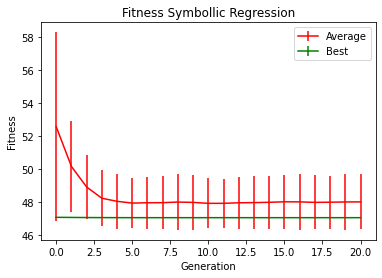

In [32]:
#plot statistics:
x = np.arange(0, MAX_GENERATIONS+1)
avgArray = np.array(avgListFitness)
stdArray = np.array(stdListFitness)
minArray = np.array(minListFitness)
maxArray = np.array(maxListFitness)

plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness Symbollic Regression')
plt.errorbar(x, avgArray.mean(0), yerr=stdArray.mean(0),label="Average",color="Red")
plt.errorbar(x, minArray.mean(0), yerr=minArray.std(0),label="Best", color="Green")
# plt.errorbar(x, maxArray.mean(0), yerr=maxArray.std(0),label="Best", color="Blue")
plt.legend()
plt.show()

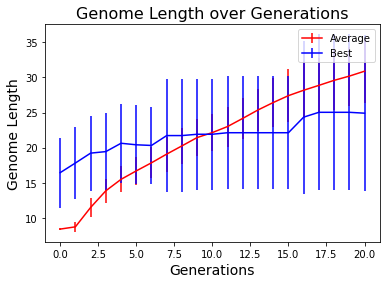

In [33]:
x = np.arange(0, MAX_GENERATIONS+1)
avgSizeArray = np.array(avgListSize)
bestSizeArray = np.array(bestListSize)
maxSizeArray = np.array(maxListSize)


plt.errorbar(x, avgSizeArray.mean(0), yerr=avgSizeArray.std(0),label="Average",color="Red")
# plt.errorbar(x, maxSizeArray.mean(0), yerr=maxSizeArray.std(0), label="Max", color="Green")
plt.errorbar(x, bestSizeArray.mean(0), yerr=bestSizeArray.std(0), label="Best", color="Blue")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.legend()
plt.show()

In [34]:
with open("out-files/statistics-cfg.txt") as file:
    content = [line.strip() for line in file.readlines()]

In [35]:
pd.Series(content).value_counts()

division by zero          703
float division by zero     40
end of run                 32
dtype: int64

In [46]:
times = pd.Series(content).value_counts()[2]
cfg1 = pd.Series(content).value_counts()[0] / times
cfg2 = pd.Series(content).value_counts()[1] / times
ag = 0

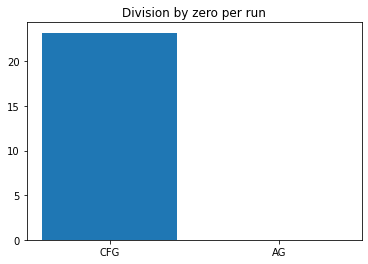

In [49]:
plt.bar(["CFG", "AG"], [cfg1+cfg2, ag])
plt.title("Division by zero per run")
plt.show()